# σ density plot for 15 sorted filters


To run this analysis, you need 15 `.fits` files, each corresponding to a separate SOM training. Each training progressively includes an additional filter, starting with the shortest wavelength and adding one at a time in order of increasing wavelength. The filters are selected to minimize overlap, ensuring each added filter contributes unique information to the training. This approach evaluates how the inclusion of more filters affects the photo-z standard deviation (σₚₑₐₖ) and identifies the point at which additional filters no longer significantly improve the results. The figure below illustrates the filter order:  
![Filters Sorted by Wavelength](table_filters_sorted.png)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.stats import gaussian_kde
import matplotlib.cm as cm


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer modern"],  # You can change the serif font here if needed
    "axes.labelsize": 14,     # Adjust as needed
    "axes.linewidth": 0.5,    # Adjust line width if necessary
    "xtick.labelsize": 12,    # Adjust tick label size
    "ytick.labelsize": 12,    
    "legend.fontsize": 12,    
    "legend.handlelength": 2.0
})

/tmp/ipykernel_20645/1597539196.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', a)


number of useful filters n>5


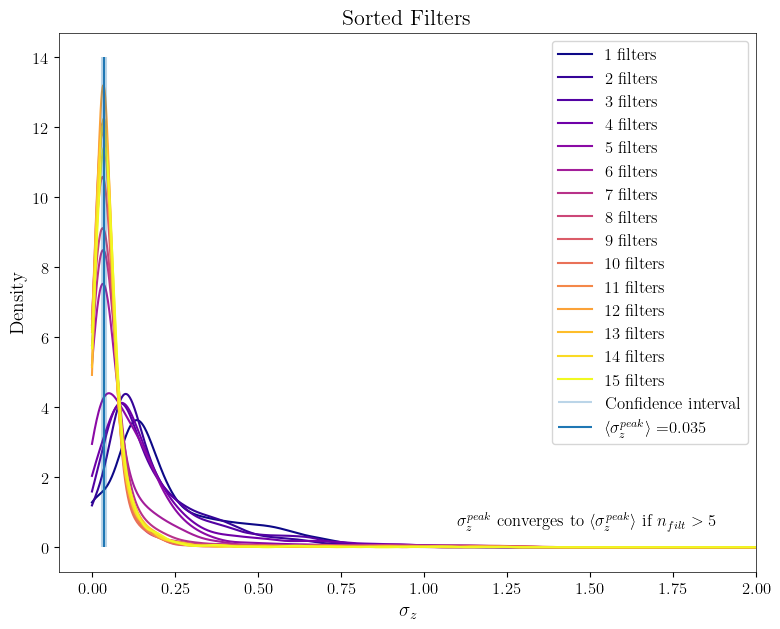

In [3]:
plt.figure(figsize=(9, 7))

file_template = 'your/path'+'SOM_Done_lp_griz_ilim_64_{}_NEW.fits' #Addapt this as you saved the various trained SOMs with different filters
somres = 64
filt_use = ['GALEX_FUV', 'GALEX_NUV', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
a = len(filt_use)

hist_data = [[] for _ in range(a)]

cmap = cm.get_cmap('plasma', a)
colors = [cmap(i) for i in range(a)]

maximum = []

for filt_index in range(a):
    sigma = []
    z_cells = [[] for _ in range(somres ** 2)]
    file_path = file_template.format(filt_index)

    try:
        data = Table.read(file_path)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        continue

    b = len(data)
    z_values = data['photoz']
    cell_classifications = data['cell'].data

    for k in range(b):
        cell_index = cell_classifications[k]
        z = z_values[k]
        z_cells[cell_index].append(z)

    for z in z_cells:
        if z:
            sigma.append(np.std(z))

    if sigma:
        kde = gaussian_kde(sigma, bw_method='scott')
        x_grid = np.linspace(min(sigma), 2, 1000)
        kde_values = kde(x_grid)
        maximum.append((max(kde_values), filt_index))
        plt.plot(x_grid, kde_values, color=colors[filt_index], label=str(filt_index + 1) + ' filters')
        
        max_kde_value = max(kde_values)
        max_index = np.where(kde_values == max_kde_value)[0][0]
        sigma_at_max_kde = x_grid[max_index]
        closest_sigma = min(sigma, key=lambda x: abs(x - sigma_at_max_kde))
        
        hist_data[filt_index] = (closest_sigma, filt_index)

hist_data.reverse()



diffs = []
for i in range(1,a):
     if maximum[i] is not None:
                diff = abs(maximum[i][0]-maximum[i-1][0])
                diffs.append((diff, i-1, i))


d_sorted = sorted(diffs, reverse=False)

jump=d_sorted[-1][1]

print('number of useful filters n>'+str(jump+1))

max_sorted=sorted(maximum,reverse=True)

hist_conv=hist_data[:(a-jump)]

sigma_values = [item[0] for item in hist_conv]

sigma_convergence = np.mean(sigma_values)


ds_in_maxs = np.std(sigma_values, ddof=1)  

lower_bound = sigma_convergence - ds_in_maxs 
upper_bound = sigma_convergence + ds_in_maxs 


plt.xlabel(r'$\sigma_{z}$')
plt.ylabel('Density')
plt.xlim(-0.1,2)
plt.legend()
plt.vlines(lower_bound,0,14,alpha=0.3, label='Confidence interval')
plt.vlines(sigma_convergence,0,14, label=r'$\langle\sigma_{z}^{peak}\rangle=$'+str(round(sigma_convergence,3)))
plt.vlines(upper_bound,0,14,alpha=0.3)
plt.legend()
plt.title('Sorted Filters', size=16)
plt.text(1.1, 0.6, r'$\sigma_{z}^{peak}$' + ' converges to ' + r'$\langle\sigma_{z}^{peak}\rangle$' + ' if ' + r'$n_{filt}>' + str(jump+1) + '$', size=12)
#plt.savefig('sorted_new', bbox_inches='tight', dpi=300)
plt.show()
